In [1]:
# %%
import ot
import numpy as np
import otmol as otm
from openbabel import pybel
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import os
# %matplotlib widget

In [ ]:
data_path = "./DataArbAlign/Water-Clusters"
#data_path = "./DataArbAlign/FGG"
mol_pair_list_path = os.path.join(data_path, 'list')

In [3]:
def RMSD(V, W):
    """ 
    Calculate Root-mean-square deviation from two sets of vectors V and W.
    """
    N = V.shape[0]
    return np.sqrt(np.sum((V-W)**2)/N)

def compare_lists(list1, list2):
    """
    Compare two lists and return the indices and elements where they differ.

    Args:
        list1 (list): The first list to compare.
        list2 (list): The second list to compare.

    Returns:
        list: A list of tuples, where each tuple contains the index and the differing elements
              in the format (index, element_from_list1, element_from_list2).
    """
    differences = []
    # Compare elements up to the length of the shorter list
    for i in range(len(list1)):
        if list1[i] != list2[i]:
            differences.append((i, list1[i], list2[i]))

    return differences

# Example usage
list1 = [1, 2, 3, 4, 5]
list2 = [1, 2, 0, 4, 6, 7]
result = compare_lists(list1, list2)
print(result)
def parse_molecule_pairs(file_path, mol_type: str = 'water cluster'):
    """
    Parses a file containing molecule pairs separated by an underscore ('_').

    Parameters:
    ----------
    file_path : str
        Path to the file containing molecule pairs.

    Returns:
    -------
    list of lists
        A list where each element is a pair [molA, molB].
    """
    molecule_pairs = []
    with open(file_path, 'r') as file:
        if mol_type == 'water cluster' or mol_type == 'S1':
            for line in file:
                line = line.strip()  # Remove any leading/trailing whitespace
                if line:  # Skip empty lines
                    # Some lines are like "molA_molB_2", and some are like "molA_molB"
                    molecule_pairs.append([line.split('_')[0], line.split('_')[1]])
        if mol_type == 'FGG':
            next(file)  # Skip the first line
            for line in file:
                line = line.strip()
                if line:
                    molA, molB = line.split('-')
                    molecule_pairs.append([molA, molB])
    return molecule_pairs
import pandas as pd

def extract_table_to_dataframe(file_path):
    """
    Extracts the table from the given file and returns it as a pandas DataFrame.

    Args:
        file_path (str): Path to the file containing the table.

    Returns:
        pd.DataFrame: A DataFrame containing the extracted table.
    """
    # Define column names based on the file structure
    column_names = [
        "Index",
        "Isomers_aligned",
        "RMSD(Conv)",
        "RMSD(KM-ByAtomName)",
        "RMSD(KM-ByAtomType)",
        "RMSD(KM-byAtomConn)"
    ]

    # Read the file, skipping the header lines (e.g., comments starting with '#')
    df = pd.read_csv(
        file_path,
        delim_whitespace=True,
        comment='#',
        names=column_names,
        skiprows=1
    )

    return df

# Example usage
file_path = "/Users/xiaoqi/otmol/DataArbAlign/FGG-Tripeptide/rmsd-2017.dat"
df = extract_table_to_dataframe(file_path)
print(df)
# Example usage
#molecule_pairs = parse_molecule_pairs(mol_pair_list_path, mol_type='FGG')
#print(molecule_pairs)

[(2, 3, 0), (4, 5, 6)]
    Index                      Isomers_aligned  RMSD(Conv)  \
0       2   253_FGG99-aligned_to-252_FGG55.xyz       2.346   
1       3  254_FGG300-aligned_to-252_FGG55.xyz       3.076   
2       4  255_FGG252-aligned_to-252_FGG55.xyz       2.741   
3       5  256_FGG366-aligned_to-252_FGG55.xyz       2.744   
4       6  257_FGG215-aligned_to-252_FGG55.xyz       2.424   
5       7  258_FGG224-aligned_to-252_FGG55.xyz       2.676   
6       8  259_FGG380-aligned_to-252_FGG55.xyz       1.635   
7       9  260_FGG412-aligned_to-252_FGG55.xyz       2.364   
8      10  261_FGG444-aligned_to-252_FGG55.xyz       2.457   
9      11  262_FGG470-aligned_to-252_FGG55.xyz       2.671   
10     12   263_FGG80-aligned_to-252_FGG55.xyz       2.390   
11     13  264_FGG114-aligned_to-252_FGG55.xyz       1.981   
12     14  265_FGG357-aligned_to-252_FGG55.xyz       2.061   
13     15  266_FGG691-aligned_to-252_FGG55.xyz       3.149   

    RMSD(KM-ByAtomName)  RMSD(KM-ByAtomType)  

In [24]:
def Experiment(mol_pair: list = None, method: str = 'fgw', #alpha: float = 0.1, 
               n_alpha: int = 10,
               coef_DD: list = None):
    """
    Experiment with ArbAlign data.
    """
    results = []
    # Load the molecule pairs from the specified file
    for nameA, nameB in mol_pair:
        molA = next(pybel.readfile('xyz', os.path.join(data_path, nameA + '.xyz')))
        molB = next(pybel.readfile('xyz', os.path.join(data_path, nameB + '.xyz')))
        # Basic processing of the molecules
        X_A, T_A, B_A = otm.tl.process_molecule(molA) # Output (1) spatial coordinates, (2) atom types, and (3) bonds as numpy arrays.
        X_B, T_B, B_B = otm.tl.process_molecule(molB)
        # Compute the distance matrices
        C = otm.tl.molecule_physchem_distance(T_A, T_B)
        C = np.where(C>0.1, 1000, C)
        D_A = otm.tl.geodesic_distance(X_A, B_A)
        D_B = otm.tl.geodesic_distance(X_B, B_B)

        if method == 'fgw':
        # Fused Gromov-Wasserstein
            DD_A = distance_matrix(X_A, X_A)
            DD_B = distance_matrix(X_B, X_B)
            alpha_list = np.linspace(0.01, 0.99, n_alpha)
            rmsd_array = np.empty((len(coef_DD), len(alpha_list)), dtype=float)
            P_array = np.empty((len(coef_DD), len(alpha_list)), dtype=object)
            for i, coef in enumerate(coef_DD):
                for j, alpha in enumerate(np.linspace(0, 1, n_alpha)):
                    P = otm.tl.molecule_optimal_transport(C, D_A+coef*DD_A, D_B+coef*DD_B, method=method, alpha=alpha)
                    #if len(np.unique(np.argmax(P, axis=1)) != X_A.shape[0]):
                    #    continue
                    X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P)
                    rmsd_array[i,j] = RMSD(X_A, X_B_aligned[np.argmax(P, axis=1)])
                    P_array[i,j] = P
            rmsd = np.min(rmsd_array)
            row_index, col_index = np.unravel_index(np.argmin(rmsd_array), rmsd_array.shape)
            optimal_coef_DD, optimal_alpha = coef_DD[row_index], alpha_list[col_index]
            optimal_P = P_array[row_index, col_index]
            optimal_assignment = np.argmax(optimal_P, axis=1)
        if len(np.unique(optimal_assignment)) != X_A.shape[0]:
            print('nameA', 'nameB', 'Warning: not a proper assignment if use np.argmax(P, axis=1)')
        results.append({
            'nameA': nameA,
            'nameB': nameB,
            'RMSD({})'.format(method): rmsd,
            '# atoms': X_A.shape[0],
            'alpha': optimal_alpha,
            'coef_DD': optimal_coef_DD,
            'assignment': optimal_assignment,
        }) 
        print(nameA, nameB, rmsd)

    return pd.DataFrame(results)

In [29]:
data_path = "./DataArbAlign/FGG-Tripeptide"
#data_path = "./DataArbAlign/FGG"
mol_pair_list_path = os.path.join(data_path, 'list')
molecule_pairs = parse_molecule_pairs(mol_pair_list_path, mol_type='FGG')
otmol_res = Experiment(molecule_pairs, method='fgw', n_alpha=100, coef_DD=np.arange(1,21))
#print(otmol_res)

252_FGG55 253_FGG99 1.7010682937728685
252_FGG55 254_FGG300 2.054926351283612
252_FGG55 255_FGG252 1.7428433687038392
252_FGG55 256_FGG366 2.0558555018335243
252_FGG55 257_FGG215 1.49818967623898
252_FGG55 258_FGG224 0.7462840440918397
252_FGG55 259_FGG380 0.9111407497170607
252_FGG55 260_FGG412 1.66350897769617
252_FGG55 261_FGG444 1.1422673356214297
252_FGG55 262_FGG470 1.2239605549284163
252_FGG55 263_FGG80 1.6109749363291572
252_FGG55 264_FGG114 1.6058299901040396
252_FGG55 265_FGG357 1.660464041887369
252_FGG55 266_FGG691 1.80078806035328


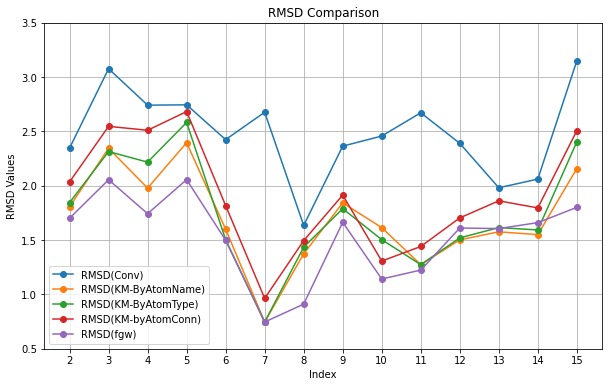

In [30]:
# Concatenate otmol_res and df along the columns
combined_df = pd.concat([otmol_res, df], axis=1)

# Ensure the column "RMSD(fgw)" exists in the combined DataFrame
if "RMSD(fgw)" not in combined_df.columns:
    combined_df["RMSD(fgw)"] = None  # Add a placeholder column if it doesn't exist

# Plot the specified columns against the Index column
columns_to_plot = ["RMSD(Conv)", "RMSD(KM-ByAtomName)", "RMSD(KM-ByAtomType)", "RMSD(KM-byAtomConn)", "RMSD(fgw)"]

# Drop any rows with missing values in the specified columns
plot_data = combined_df.dropna(subset=columns_to_plot)

plt.figure(figsize=(10,6))
# Plot each column against the Index column
for column in columns_to_plot:
    plt.plot(plot_data["Index"], plot_data[column], marker='o', label=column)
plt.title("RMSD Comparison")
plt.xlabel("Index")
plt.ylabel("RMSD Values")
plt.ylim(0.5, 3.5)
plt.xticks(range(2,16))
plt.legend()
plt.grid(True)

In [31]:
for item in otmol_res['assignment']:
    print(len(item))

37
37
37
37
37
37
37
37
37
37
37
37
37
37


In [ ]:
"""
data_path = "./DataArbAlign/S1-MA-W1"
#data_path = "./DataArbAlign/FGG"
mol_pair_list_path = os.path.join(data_path, 'list')
molecule_pairs = parse_molecule_pairs(mol_pair_list_path, mol_type='S1')
Experiment(molecule_pairs, method='fgw', alpha=0.4)"
"""

In [46]:
# %%
# Read the molecules
molA = next(pybel.readfile("xyz", "./DataArbAlign/FGG-Tripeptide/252_FGG55.xyz"))
molB = next(pybel.readfile("xyz", "./DataArbAlign/FGG-Tripeptide/253_FGG99.xyz"))
#molA = next(pybel.readfile("xyz", "./DataArbAlign/S1-MA-W1/s1maw1-1.xyz"))

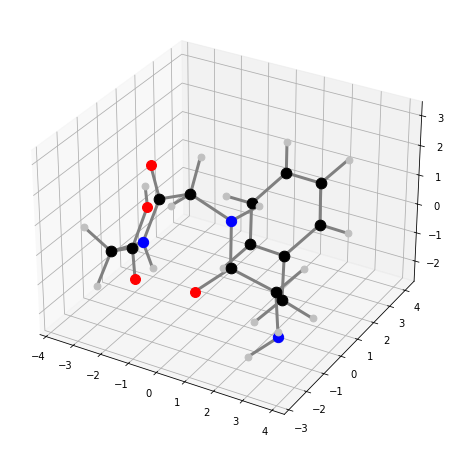

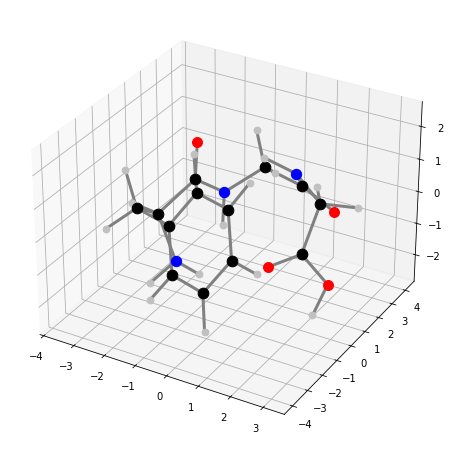

In [47]:
# %%
# Basic processing of the molecules
X_A, T_A, B_A = otm.tl.process_molecule(molA) # Output (1) spatial coordinates, (2) atom types, and (3) bonds as numpy arrays.
X_B, T_B, B_B = otm.tl.process_molecule(molB)
otm.pl.plot_molecule(X_A, T_A, B_A, coloring = 'type', sizing = 'type')
otm.pl.plot_molecule(X_B, T_B, B_B, coloring = 'type', sizing = 'type')

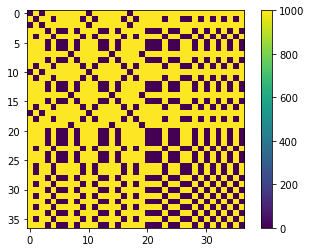

In [48]:
# %%
C = otm.tl.molecule_physchem_distance(T_A, T_B)
D_A = otm.tl.geodesic_distance(X_A, B_A)
D_B = otm.tl.geodesic_distance(X_B, B_B)
C = np.where(C>0.1, 1000, C)
plt.show()
plt.imshow(C)
plt.colorbar()

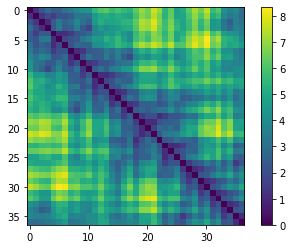

In [49]:

# %%
# Fused Gromov-Wasserstein
DD_A = distance_matrix(X_A, X_A)
DD_B = distance_matrix(X_B, X_B)
P = otm.tl.molecule_optimal_transport(C, D_A+5*DD_A, D_B+5*DD_B, method='fgw', alpha=0.9)
plt.show()
plt.imshow(DD_A)
plt.colorbar()

2.2094047011113522
[]


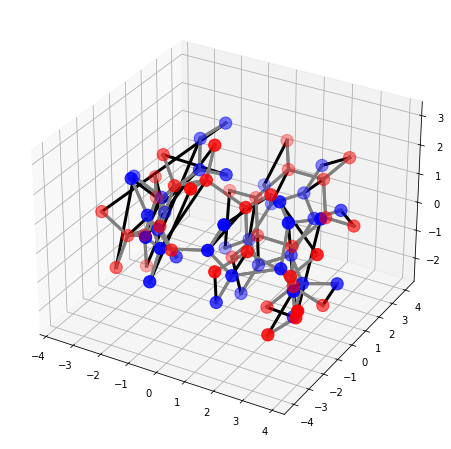

In [62]:
X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P) 
print(RMSD(X_A, X_B_aligned[np.argmax(P, axis=1)]))
print(compare_lists(T_A, T_B[np.argmax(P, axis=1)]))
otm.pl.plot_alignment(X_A, X_B_aligned, B_A, B_B, P, weight_cutoff=0.01)
plt.show()

2.237235753083236


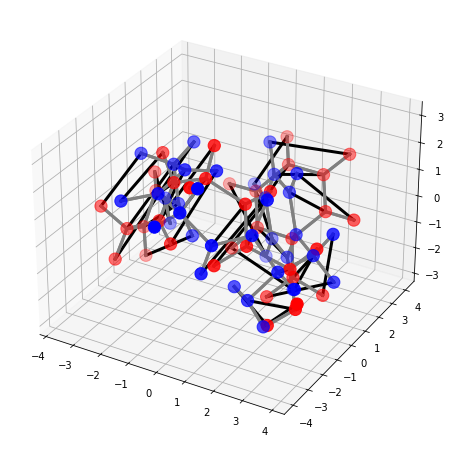

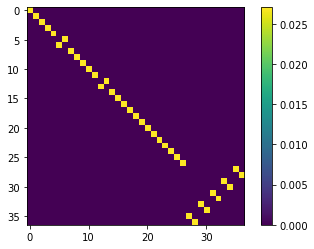

In [23]:
# %%
# Gromov-Wasserstein
P = otm.tl.molecule_optimal_transport(C, D_A, D_B, method='gw', alpha=0.9)
X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P)
otm.pl.plot_alignment(X_A, X_B_aligned, B_A, B_B, P)
print(RMSD(X_A, X_B_aligned[np.argmax(P, axis=1)]))
plt.show()
plt.imshow(P)
plt.colorbar()


No more edges in the graph.
2.1552160380660763


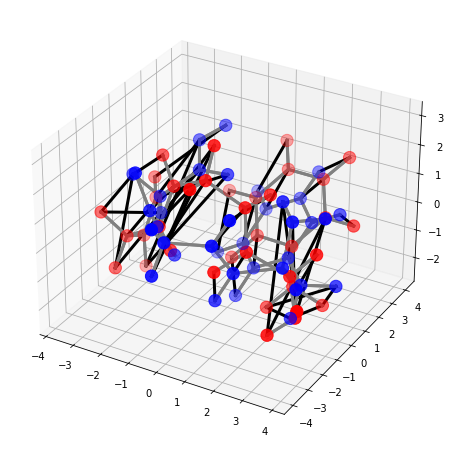

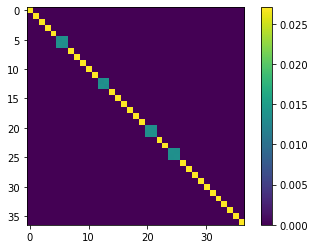

In [19]:
# %%
# Supervised Gromov-Wasserstein
P = otm.tl.molecule_optimal_transport(C, D_A, D_B, method='sgw', sgw_cutoff=5)
X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P)
otm.pl.plot_alignment(X_A, X_B_aligned, B_A, B_B, P)
print(RMSD(X_A, X_B_aligned[np.argmax(P, axis=1)]))
plt.show()
plt.imshow(P)
plt.colorbar()

# of potential non-zeros in P: 210
2.1552260859951216
[]


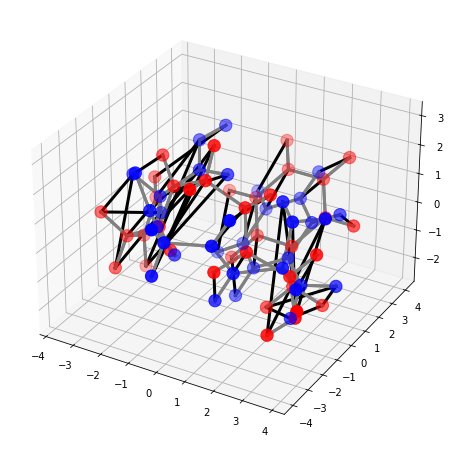

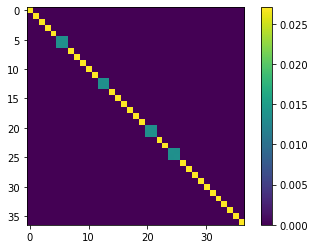

In [20]:
# %%
# Fused supervised Gromov-Wasserstein
P = otm.tl.molecule_optimal_transport(C, D_A, D_B, method='fsgw', sgw_cutoff=5, alpha=0.5)
X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P)
otm.pl.plot_alignment(X_A, X_B_aligned, B_A, B_B, P)
print(RMSD(X_A, X_B_aligned[np.argmax(P, axis=1)]))
print(compare_lists(T_A, T_B[np.argmax(P, axis=1)]))
plt.show()
plt.imshow(P)
plt.colorbar()